In [ ]:
---
title: "Data Exploration and Analysis with Python and Quarto"
format:
  html:
    code-fold: true
jupyter: python3
---

# Data Exploration and Analysis with Python
## Introduction
Matching Data from different sources can be a challenging task since not all data are created equal.
One tedious task is linking strings with eachother which are not 1:1 matching keys. Fuzzy string matching is a technique used to compare and identify similarities between strings, even when they are not an exact match. This approach is highly relevant for data analysis tasks that involve text or string data. It plays a crucial role in several use cases, one of them being record linkage.



## Main libraries utilized


*   pandas for interaction with our data
*   geopandas for interaction with our spatial data
*   plotly for visualizing our data
*   rapidfuzz for fuzzy string matching
*

## Data used
In this example I exported chat history from a group called "Schwarzkappler" on telegram where chat participants can report ticket controls in the Vienna Metropolitan area. The reports are free-form non structured data attached with a timestamp and a message.
Problematic is that we have no control over the quality of reports, their spelling and their structure. For this short session we will concentrate on finding matches not on overall best accuracy of matches.



In [15]:
#@title install required libraries
!pip install folium matplotlib mapclassify
!pip install geopandas
!pip install rapidfuzz
!pip install pandas
#!pip install plotly==4.4.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Here we import the required libraries

In [17]:
import pandas as pd
import numpy as np
import geopandas as gpd
from datetime import datetime

import json
from pandas import json_normalize
import plotly.express as px
import plotly.io as pio


from rapidfuzz.process import cdist
from rapidfuzz import process, utils
from rapidfuzz import fuzz


pio.renderers.default = "plotly_mimetype+notebook_connected"



In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Preprocess the data

Creating a function to preprocess a JSON export from telegram. This returns a Pandas Dataframe with a date and text column.
(source: https://github.com/zachlim98/TeleVisuals/blob/main/TeleVisuals/TeleVisuals.py)

In [19]:
def chat_clean(file_path):
    '''Enter the file_path for .json Telegram Chat export'''
    with open(file_path, encoding="utf8") as f:
        d = json.load(f)
    norm_msg = json_normalize(d['messages'])
    msg_df = pd.DataFrame(norm_msg)
    msg_df_filtered = msg_df[msg_df.type=="message"]
    msg_df_filtered = msg_df_filtered[["date","text"]]
    #msg_df_filtered['text'] = msg_df_filtered['text'].str.replace('[^A-Za-z0-9]+', " ")
    msg_df_filtered = msg_df_filtered.dropna()

    return msg_df_filtered


### Apply the function chat_clean on our data.

The data stems from a telegram group called schwarzkappler where users can report ticket control incidents in an unstructured style. Messages contain a timestamp from telegrams structure and in most cases users report at least a station name. Often times there are also direction names and the line number.



Because we are short on time we try to find the most relevant match in the message not focusing on order and line number. This will lead to less accurate results but it demonstrates the workflow and the potential time-saving benefits of it.

In [20]:
df = chat_clean("/content/drive/MyDrive/Colab Notebooks/schwarzkappler_export.json")

### Adjusting column types

For further processing we need to adjust the data type of the text column. By default the dtype is object, we need to specify it as string.

In [21]:
df = df.astype({"text":"string"})

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24103 entries, 33 to 24590
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    24103 non-null  object
 1   text    24103 non-null  string
dtypes: object(1), string(1)
memory usage: 564.9+ KB


## Opening Dataframe with location data and station name for string matching
Since we want to map our results we need location data for our messages to match the text and time to a location. Therefore we import data from the open data initiative of Vienna's City Administration.
Data source:
https://www.data.gv.at/katalog/dataset/21fca925-12ac-4215-ba1a-a9c73cb3b082#resources

To work with geodata (data with a location component) we are using a module built on-top of pandas for a similar interaction experience with our data.
https://geopandas.org/en/stable/

In [23]:
gdf = gpd.read_file("/content/drive/MyDrive/Colab Notebooks/wien_shp/OEFFHALTESTOGDPoint.shp")

In [24]:
gdf = gdf.astype({"HTXT":"string"})

## Fuzzy Matching using radidfuzz library
The library used for string matching is rapidfuzz. There is another popular library called fuzzywuzzy but rapidfuzz is so much faster in our use case, because it is mainly running C-Code through an python interface. We have to compare each message to all station names in order to potentially find one station name for each message. Since our message list is ~24k message and we compare to ~6k station names we have around 160.000.000 comparisons to do. There small performance gains lead to big improvements in overall speed.

### Preprocessing for matching


rapidfuzz.utils.default_process(sentence: str) → str




This function preprocesses a string by:
*   removing all non alphanumeric characters
*   trimming whitespaces
*   converting all characters to lower case

https://maxbachmann.github.io/RapidFuzz/Usage/utils.html




In [25]:
#Preprocess Text Column for fuzzy string matching
text = df['text']
processed_text = [utils.default_process(tx) for tx in text]

In [26]:
#Preprocess Text Column for fuzzy string matching
htxt = gdf['HTXT']
processed_htxt = [utils.default_process(ht) for ht in htxt]

In [27]:
len(processed_text), len(processed_htxt)

(24103, 6818)

### Do the actual comparissons and fuzzy matching
cdist: Computes distance/similarity between each pair of the two collections of inputs. Returns a matrix of dtype with the distance/similarity between each pair of the two collections of inputs.

As Inputs we use our preprocessed lists obtained from our two dataframes containing all messages and all station names. For each message we want the scores of all station names. After that we are only interrested in the highest ranked match (the closest similarity of station name in a given message).
We want to know the index (as in excel the row number) of the maximum score.

*Further down the notebook there are some lines of code for deciding upon the scorer to use and the score_cutoff value exploration.*


In [28]:
#Make an Array with every message as row (y-axis)
#And Score for every Public-Transport-Station (x-Axis) for every message
cdist_test = cdist(processed_text, processed_htxt, scorer=fuzz.token_set_ratio, score_cutoff=85, workers=-1)
#Return Index of Public-Transport-Sation of highest scoring element => Used for Matching the Message with Station-Name
cdist_max = np.argmax(cdist_test, axis=1)


In [29]:
cdist_test.shape

(24103, 6818)

In [30]:
cdist_max.shape

(24103,)

In [31]:
cdist_max

array([1401,    0, 1325, ...,    0,    0,    0])

### Make the results of the string matching more accessible for further analysis
Now that we have a list containing the best matching station indices with the same length as the dataframe with our messages we can create a new column containing this information.
Since from now on we are only interested in messages for which we found a matching station name we can reduce the number of elements in the according data frame. Afterwards we can merge the message dataframe with the one containing station information.

In [32]:
#Create Match Index Column with result above
df["match_idx"] = cdist_max
#We are only interested in Stations found in Messages
matching_gdf = gdf.iloc[cdist_max[cdist_max != 0]]
matching_gdf['gdf_idx'] = matching_gdf.index

#We dont need all entries for one Station-Name
matching_gdf = matching_gdf.drop_duplicates()

# Reset the index of `matching_gdf` to be unique
matching_gdf = matching_gdf.reset_index(drop=True)

# Merge `df` and `matching_gdf` using the 'match_idx' column
result = pd.merge(df, matching_gdf, left_on='match_idx', right_on='gdf_idx')

# Drop the 'match_idx' column from the result if desired
#result = result.drop(columns=['match_idx'])

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [33]:
result

date                                               text  \
0      2019-11-13T12:22:07                               Kontrolle Karlsplatz   
1      2019-11-20T16:38:22      Gibt's momentan eine Kontrolle am Karlsplatz?   
2      2019-11-22T16:40:19            Kontrolle Karlsplatz Aufgang von der u4   
3      2019-11-22T16:43:44  Mobil u2 Richtung Karlsplatz.... Eine Frau Kle...   
4      2019-11-22T17:22:41                 U4 Karlsplatz immer noch stationär   
...                    ...                                                ...   
14190  2023-05-16T09:44:15  37a kontrolle, sind vorhin in der Gregor-Mende...   
14191  2023-05-18T17:43:32                                          Ottakring   
14192  2023-05-21T16:48:17                                  Schlachthausgasse   
14193  2023-05-22T16:45:36  60er bim, sind gerade winckelmannstraße ausges...   
14194  2023-05-26T09:47:18                                             gruppe   

       match_idx   OBJECTID                           HTXT  \
0           1401  2057595.0                     Karlsplatz   
1           1401  2057595.0                     Karlsplatz   
2           1401  2057595.0                     Karlsplatz   
3           1401  2057595.0                     Karlsplatz   
4           1401  2057595.0                     Karlsplatz   
...          ...        ...                            ...   
14190        897  2056919.0           Gregor-Mendel-Straße   
14191        330  2051109.0               Klinik Ottakring   
14192        863  2057248.0  Erdbergstr./Schlachthausgasse   
14193       5373  2051601.0              Winckelmannstraße   
14194       4391  2052051.0     Zentralfriedhof Gruppe 121   

                               HTXTK  \
0                         Karlsplatz   
1                         Karlsplatz   
2                         Karlsplatz   
3                         Karlsplatz   
4                         Karlsplatz   
...                              ...   
14190           Gregor-Mendel-Straße   
14191               Klinik Ottakring   
14192  Erdbergstr./Schlachthausgasse   
14193              Winckelmannstraße   
14194     Zentralfriedhof Gruppe 121   

                                                 HLINIEN  DIVA_ID  LTYP  \
0      G1, N60, 59A, U4, BB, 1, 096, N46, U1, 311, 62...      NaN   4.0   
1      G1, N60, 59A, U4, BB, 1, 096, N46, U1, 311, 62...      NaN   4.0   
2      G1, N60, 59A, U4, BB, 1, 096, N46, U1, 311, 62...      NaN   4.0   
3      G1, N60, 59A, U4, BB, 1, 096, N46, U1, 311, 62...      NaN   4.0   
4      G1, N60, 59A, U4, BB, 1, 096, N46, U1, 311, 62...      NaN   4.0   
...                                                  ...      ...   ...   
14190                                           40A, 37A      NaN   2.0   
14191                                           48A, N46      NaN   2.0   
14192                                                 18      NaN   1.0   
14193                           52, 60, 18, 49, 9, 10, 5      NaN   1.0   
14194                                                 ZF      NaN   2.0   

                                                WEBLINK1  \
0      https://anachb.vor.at#P|SQ!evaId|Wien%20Karlsp...   
1      https://anachb.vor.at#P|SQ!evaId|Wien%20Karlsp...   
2      https://anachb.vor.at#P|SQ!evaId|Wien%20Karlsp...   
3      https://anachb.vor.at#P|SQ!evaId|Wien%20Karlsp...   
4      https://anachb.vor.at#P|SQ!evaId|Wien%20Karlsp...   
...                                                  ...   
14190  https://anachb.vor.at#P|SQ!evaId|Wien%20Gregor...   
14191  https://anachb.vor.at#P|SQ!evaId|Wien%20Klinik...   
14192  https://anachb.vor.at#P|SQ!evaId|Wien%20Erdber...   
14193  https://anachb.vor.at#P|SQ!evaId|Wien%20Wincke...   
14194  https://anachb.vor.at#P|SQ!evaId|Wien%20Zentra...   

                        geometry  gdf_idx  
0      POINT (16.36895 48.20096)     1401  
1      POINT (16.36895 48.20096)     1401  
2      POINT (16.36895 48.20096)     1401  
3      POINT (16.36895 48

### Adjust the location data and export file
We have found the matches, they are not perfect, but for the effort so far the results look promising and for our purposes they will suffice.  In order to save our progress we export the results to a file from type "Geopackage" which is built on top of sqlite and is able to handle location data.
*If something along the analysis so far did not work on your machine we can start together afterwards*

In [34]:
#Create Dataframe in Geopandas, which handles Geometries and Projections so we can map our results
result_gdf = gpd.GeoDataFrame(result, geometry=result.geometry, crs=4326)

In [35]:
#Export our Results to GeoPackage File Format
result_gdf.to_file("wien_kontrollen_matched.gpkg", driver="GPKG")

In [36]:
result_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 14195 entries, 0 to 14194
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   date       14195 non-null  object  
 1   text       14195 non-null  string  
 2   match_idx  14195 non-null  int64   
 3   OBJECTID   14195 non-null  float64 
 4   HTXT       14195 non-null  string  
 5   HTXTK      14195 non-null  object  
 6   HLINIEN    14195 non-null  object  
 7   DIVA_ID    0 non-null      float64 
 8   LTYP       14195 non-null  float64 
 9   WEBLINK1   14195 non-null  object  
 10  geometry   14195 non-null  geometry
 11  gdf_idx    14195 non-null  int64   
dtypes: float64(3), geometry(1), int64(2), object(4), string(2)
memory usage: 1.4+ MB


### Work with datetime information
Now that we have the location appended to our messages we need to utilize the date-time information attached to the messages. Therefore we are processing the date column and appending several other columns containing for example the hour of day.

We want to find out when and where there are hotspots of control incidents.

To achieve this we will group our data by hour and station name giving us the count of incidents per hour and station. We can use station name and location as synonyms because we only kept 1 station name and location despite one station name containing more than 1 location (different entries and exits per subway-station, ...) but we don't have information this fine-grained.

In [37]:
#Rework our GeoDataframe Time-Information in order to make animations
result_gdf["dt_obj"] = result_gdf["date"].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S"))

In [38]:
#Rework our GeoDataframe Time-Information in order to make animations
result_gdf["hour"] = result_gdf["dt_obj"].apply(lambda x : x.hour)

In [39]:
# Group by 'hour' and 'geometry' and count the number of elements per group
grouped = result_gdf.groupby(["hour", "geometry", "HTXT"]).size()

# Rename the count column to 'count'
grouped = grouped.rename('count')

# Convert the resulting Series back to a DataFrame
grouped = grouped.to_frame().reset_index()

In [40]:
import plotly.express as px

In [41]:
grouped_gdf = gpd.GeoDataFrame(grouped, geometry=grouped.geometry, crs=4326)

In [42]:
grouped_gdf = grouped_gdf.to_crs(4326)
grouped_gdf['lon'] = grouped_gdf.centroid.x
grouped_gdf['lat'] = grouped_gdf.centroid.y

<ipython-input-42-a71913a16aca>:2: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


<ipython-input-42-a71913a16aca>:3: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




In [43]:
grouped_gdf

hour                   geometry              HTXT  count        lon  \
0        0  POINT (16.34224 48.18829)  Margaretengürtel      1  16.342242   
1        0  POINT (16.33199 48.17437)          Meidling      1  16.331992   
2        0  POINT (16.26107 48.19741)        Hütteldorf      1  16.261070   
3        0  POINT (16.38403 48.24111)        Handelskai      2  16.384031   
4        0  POINT (16.33765 48.19666)       Westbahnhof      1  16.337651   
...    ...                        ...               ...    ...        ...   
2301    23  POINT (16.39233 48.21854)       Praterstern      1  16.392332   
2302    23  POINT (16.45063 48.27698)         Leopoldau      2  16.450632   
2303    23  POINT (16.40030 48.25682)       Floridsdorf      1  16.400300   
2304    23  POINT (16.42001 48.17019)         Simmering      1  16.420009   
2305    23  POINT (16.41750 48.18548)         Gasometer      1  16.417502   

            lat  
0     48.188290  
1     48.174367  
2     48.197414  
3     48.241109  
4     48.196656  
...         ...  
2301  48.218541  
2302  48.276975  
2303  48.256821  
2304  48.170186  
2305  48.185475  

[2306 rows x 6 columns]

In [44]:
np.mean(grouped_gdf["lon"])

16.367726467740667

In [45]:
fig = px.density_mapbox(grouped_gdf, lat='lat', lon='lon', z='count', radius=15,
                        center=dict(lat=np.mean(grouped_gdf["lat"]), lon=np.mean(grouped_gdf["lon"])), zoom=11,
                        mapbox_style="stamen-terrain")
fig.show()

In [46]:
fig = px.density_mapbox(grouped_gdf, lat='lat', lon='lon', z='count', radius=15, hover_data=["hour", "HTXT"],
                        center=dict(lat=np.mean(grouped_gdf["lat"]), lon=np.mean(grouped_gdf["lon"])), zoom=11,
                        mapbox_style="stamen-terrain")
fig.show()

In [47]:
import plotly.express as px

fig = px.scatter(grouped_gdf, x="lon", y="lat", animation_frame="hour", animation_group="HTXT",
           size="count",  hover_name="HTXT",
           log_x=True, size_max=55, range_x=[np.min(grouped_gdf["lon"]),np.max(grouped_gdf["lon"])],
                                    range_y=[np.min(grouped_gdf["lat"]),np.max(grouped_gdf["lat"])])

fig["layout"].pop("updatemenus") # optional, drop animation buttons
fig.show()

In [48]:
import plotly.express as px

fig = px.scatter_mapbox(grouped_gdf, lat='lat', lon='lon',  hover_data=["hour", "HTXT"],
                        center=dict(lat=np.mean(grouped_gdf["lat"]), lon=np.mean(grouped_gdf["lon"])), zoom=11,
                        mapbox_style="stamen-terrain", animation_frame="hour", animation_group="HTXT",
           size="count",  hover_name="HTXT")

fig["layout"].pop("updatemenus") # optional, drop animation buttons
fig.show()

In [49]:
fig = px.density_mapbox(grouped_gdf, lat='lat', lon='lon', z='count', radius=20, hover_data=["hour", "HTXT"], animation_frame="hour", animation_group="HTXT",
                        center=dict(lat=np.mean(grouped_gdf["lat"]), lon=np.mean(grouped_gdf["lon"])), zoom=10.5,
                        mapbox_style="stamen-terrain")
fig["layout"].pop("updatemenus") # optional, drop animation buttons

fig.show()

In [50]:
grouped_gdf.head()

hour                   geometry              HTXT  count        lon  \
0     0  POINT (16.34224 48.18829)  Margaretengürtel      1  16.342242   
1     0  POINT (16.33199 48.17437)          Meidling      1  16.331992   
2     0  POINT (16.26107 48.19741)        Hütteldorf      1  16.261070   
3     0  POINT (16.38403 48.24111)        Handelskai      2  16.384031   
4     0  POINT (16.33765 48.19666)       Westbahnhof      1  16.337651   

         lat  
0  48.188290  
1  48.174367  
2  48.197414  
3  48.241109  
4  48.196656

In [51]:
groupable = grouped[[ "HTXT", "count"]]
# Regroup by hour only
grouped_station = groupable.groupby(["HTXT"]).sum()

# Rename the count column to 'count'
#grouped_station = grouped_station.rename('count')

# Convert the resulting Series back to a DataFrame
grouped_station = grouped_station.reset_index()


In [52]:
grouped_station

HTXT  count
0         Absberggasse     22
1    Aderklaaer Straße      3
2          Alaudagasse     14
3               Albern      1
4          Albertgasse      3
..                 ...    ...
411    Ziegelofengasse      5
412       Zieglergasse    124
413       Ziehrerplatz      1
414     Zippererstraße     11
415      Zschokkegasse      2

[416 rows x 2 columns]

In [53]:
grouped_station.nlargest(15, columns="count")

HTXT  count
171     Karlsplatz    701
279    Praterstern    620
391    Westbahnhof    618
319  Schwedenplatz    564
230       Meidling    558
144     Hütteldorf    522
86     Floridsdorf    506
313    Schottentor    506
123     Handelskai    481
312   Schottenring    414
207      Leopoldau    371
261      Ottakring    361
336      Simmering    360
128  Heiligenstadt    357
382   Volkstheater    310

In [54]:
grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2306 entries, 0 to 2305
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   hour      2306 non-null   int64   
 1   geometry  2306 non-null   geometry
 2   HTXT      2306 non-null   string  
 3   count     2306 non-null   int64   
dtypes: geometry(1), int64(2), string(1)
memory usage: 72.2 KB


In [55]:
fig = px.histogram(grouped_gdf, x='hour', y='count')
fig.show()

In [56]:
grouped_gdf.head()

hour                   geometry              HTXT  count        lon  \
0     0  POINT (16.34224 48.18829)  Margaretengürtel      1  16.342242   
1     0  POINT (16.33199 48.17437)          Meidling      1  16.331992   
2     0  POINT (16.26107 48.19741)        Hütteldorf      1  16.261070   
3     0  POINT (16.38403 48.24111)        Handelskai      2  16.384031   
4     0  POINT (16.33765 48.19666)       Westbahnhof      1  16.337651   

         lat  
0  48.188290  
1  48.174367  
2  48.197414  
3  48.241109  
4  48.196656

In [57]:
result.iloc[10977]["text"]

'Auch bei rennweg 2 am bahnsteig'

In [58]:
test_df = df.iloc[0:50]
test_text = test_df['text']
test_processed_text = [utils.default_process(tx) for tx in test_text]

In [59]:
for (i, processed_query) in enumerate(test_processed_text):
  match_htxt = process.extractOne(processed_query, processed_htxt, processor=None, score_cutoff=87)
  print(match_htxt)


('karlsplatz', 90.0, 1401)
None
('schottentor', 90.0, 1325)
('volkstheater', 100.0, 1575)
('cumberlandstraße', 90.0, 126)
('meidling', 90.0, 1355)
None
('friedrich engels platz', 90.0, 3333)
('spittelau', 90.0, 1361)
None
('stadion', 90.0, 1415)
None
('seestadt', 90.0, 1345)
('hauptbahnhof', 90.0, 1567)
None
('schottenring', 95.0, 1324)
None
('vorgartenstraße', 90.0, 1576)
('westbahnhof', 90.0, 1305)
None
None
('zieglergasse', 90.0, 1311)
('karlsplatz', 90.0, 1401)
None
None
None
('floridsdorf', 90.0, 1430)
None
None
('volkstheater', 90.0, 1575)
None
('volkstheater', 90.0, 1575)
None
None
('kahlenberg', 90.0, 808)
None
None
('krausegasse', 90.0, 3182)
('schottenring', 90.0, 1324)
('gasometer', 90.0, 554)
('schottenring', 90.0, 1324)
None
('reumannplatz', 90.0, 1364)
None
None
None
None
None
None
None


In [60]:
for (i, processed_query) in enumerate(test_processed_text):
  match_htxt = process.extract(processed_query, processed_htxt, scorer=fuzz.WRatio, limit=5, score_cutoff=85)
  print(match_htxt)
  print(processed_query)
  print("---------------------------------------------")
  print("---------------------------------------------")

[('karlsplatz', 90.0, 1401), ('karlsplatz', 90.0, 3712), ('karlsplatz', 90.0, 3713), ('karlsplatz', 90.0, 3714), ('karlsplatz', 90.0, 3715)]
kontrolle karlsplatz
---------------------------------------------
---------------------------------------------
[]
schau ma was sich mehr auszahlt
---------------------------------------------
---------------------------------------------
[('schottentor', 90.0, 1325), ('schottentor', 90.0, 5173), ('schottentor', 90.0, 5174), ('schottentor', 90.0, 5175), ('schottentor', 90.0, 5176)]
u2  station schottentor  zivil  kurze graue haare schwarze lederjacke
---------------------------------------------
---------------------------------------------
[('volkstheater', 100.0, 1575), ('volkstheater', 100.0, 4852), ('volkstheater', 100.0, 4853), ('volkstheater', 100.0, 4854), ('volkstheater', 100.0, 4855)]
volkstheater
---------------------------------------------
---------------------------------------------
[('cumberlandstraße', 90.0, 126), ('cumberlandstra

In [61]:
from rapidfuzz.process import cdist
cdist_test = cdist(processed_text, processed_htxt, scorer=fuzz.token_set_ratio, score_cutoff=85, workers=-1)

In [62]:
duplicates_list = []

for distances in cdist_test:
    # Get indices of duplicates
    indices = np.argwhere(~np.isin(distances, [100, 0])).flatten()
    # Get names from indices
    names = list(map(processed_htxt.__getitem__, indices))
    duplicates_list.append(names)

In [63]:
df["match_idx"] = cdist_max

In [64]:
matching_gdf = gdf.iloc[cdist_max[cdist_max != 0]]

In [65]:
#matching_gdf = gdf.iloc[cdist_max[cdist_max != 0]]
matching_gdf = gdf.iloc[cdist_max[cdist_max != 0]]
matching_gdf['gdf_idx'] = matching_gdf.index
matching_gdf = matching_gdf.drop_duplicates()

# Reset the index of `matching_gdf` to be unique
matching_gdf = matching_gdf.reset_index(drop=True)

# Merge `df` and `matching_gdf` using the 'match_idx' column
result = pd.merge(df, matching_gdf, left_on='match_idx', right_on='gdf_idx')

# Drop the 'match_idx' column from the result if desired
#result = result.drop(columns=['match_idx'])

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [66]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14195 entries, 0 to 14194
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   date       14195 non-null  object  
 1   text       14195 non-null  string  
 2   match_idx  14195 non-null  int64   
 3   OBJECTID   14195 non-null  float64 
 4   HTXT       14195 non-null  string  
 5   HTXTK      14195 non-null  object  
 6   HLINIEN    14195 non-null  object  
 7   DIVA_ID    0 non-null      float64 
 8   LTYP       14195 non-null  float64 
 9   WEBLINK1   14195 non-null  object  
 10  geometry   14195 non-null  geometry
 11  gdf_idx    14195 non-null  int64   
dtypes: float64(3), geometry(1), int64(2), object(4), string(2)
memory usage: 1.4+ MB


In [67]:
gdf_result = gpd.GeoDataFrame(result, crs="EPSG:4326", geometry=result.geometry)

In [68]:
!pip install geoplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 28.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 4.4 MB/s eta 0:00:00
  Created wheel for cartopy: filename=Cartopy-0.21.1-cp310-cp310-linux_x86_64.whl size=11102751 sha256=be82dda3fa958766e21cfc9a28610347d94f79d2efa5772ffd4ef8543f8c361b
  Stored in directory: /root/.cache/pip/wheels/30/b0/1a/1c1909e00c76653dc4e2ff48555257c0eb2d1698280c8d9955
Successfully built cartopy


AttributeError: ignored

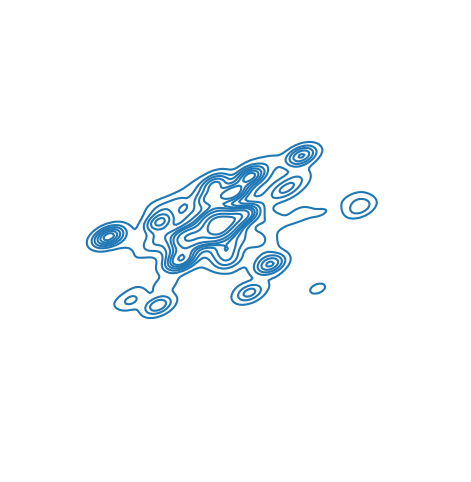

In [69]:
# Import geoplot
import geoplot
import geoplot.crs as gcrs

# Plot heatmap
ax = geoplot.kdeplot(gdf_result) #, projection=gcrs.AlbersEqualArea())

# Add polygons
geoplot.polyplot(gdf_result, ax=ax)

In [70]:
df.head(100)

date                                               text  \
33   2019-11-13T12:22:07                               Kontrolle Karlsplatz   
55   2019-11-13T13:12:55                    schau ma was sich mehr auszahlt   
70   2019-11-13T13:58:06  U2 -Station Schottentor; zivil, kurze graue Ha...   
117  2019-11-14T08:14:38                                       Volkstheater   
122  2019-11-14T09:34:19                                         Landstraße   
..                   ...                                                ...   
514  2019-11-27T15:41:59                             Praterstern entwarnung   
531  2019-11-28T07:44:58  S-Bahn Liesing Richtung Wien: Kontrollen im Zu...   
534  2019-11-28T09:31:35                                 U6 Währingerstraße   
535  2019-11-28T09:39:11                     U3 Johnstraße: Ticketkontrolle   
541  2019-11-28T13:13:41                          U3 Volkstheater stationär   

     match_idx  
33        1401  
55           0  
70        1325  
117         31  
122       1368  
..         ...  
514       1359  
531        682  
534          0  
535        922  
541       1575  

[100 rows x 3 columns]

In [71]:
df

date                                               text  \
33     2019-11-13T12:22:07                               Kontrolle Karlsplatz   
55     2019-11-13T13:12:55                    schau ma was sich mehr auszahlt   
70     2019-11-13T13:58:06  U2 -Station Schottentor; zivil, kurze graue Ha...   
117    2019-11-14T08:14:38                                       Volkstheater   
122    2019-11-14T09:34:19                                         Landstraße   
...                    ...                                                ...   
24586  2023-06-02T19:28:08                                          Auch Lift   
24587  2023-06-02T19:39:46  U1 Karlsplatz und Oper Ausgang Kontrolle stati...   
24588  2023-06-02T19:51:16                                       Still active   
24589  2023-06-02T19:58:07                                            Ongoing   
24590  2023-06-02T20:09:39                                  Oper Ausgang frei   

       match_idx  
33          1401  
55             0  
70          1325  
117           31  
122         1368  
...          ...  
24586          0  
24587       1401  
24588          0  
24589          0  
24590          0  

[24103 rows x 3 columns]

In [72]:
result

date                                               text  \
0      2019-11-13T12:22:07                               Kontrolle Karlsplatz   
1      2019-11-20T16:38:22      Gibt's momentan eine Kontrolle am Karlsplatz?   
2      2019-11-22T16:40:19            Kontrolle Karlsplatz Aufgang von der u4   
3      2019-11-22T16:43:44  Mobil u2 Richtung Karlsplatz.... Eine Frau Kle...   
4      2019-11-22T17:22:41                 U4 Karlsplatz immer noch stationär   
...                    ...                                                ...   
14190  2023-05-16T09:44:15  37a kontrolle, sind vorhin in der Gregor-Mende...   
14191  2023-05-18T17:43:32                                          Ottakring   
14192  2023-05-21T16:48:17                                  Schlachthausgasse   
14193  2023-05-22T16:45:36  60er bim, sind gerade winckelmannstraße ausges...   
14194  2023-05-26T09:47:18                                             gruppe   

       match_idx   OBJECTID                           HTXT  \
0           1401  2057595.0                     Karlsplatz   
1           1401  2057595.0                     Karlsplatz   
2           1401  2057595.0                     Karlsplatz   
3           1401  2057595.0                     Karlsplatz   
4           1401  2057595.0                     Karlsplatz   
...          ...        ...                            ...   
14190        897  2056919.0           Gregor-Mendel-Straße   
14191        330  2051109.0               Klinik Ottakring   
14192        863  2057248.0  Erdbergstr./Schlachthausgasse   
14193       5373  2051601.0              Winckelmannstraße   
14194       4391  2052051.0     Zentralfriedhof Gruppe 121   

                               HTXTK  \
0                         Karlsplatz   
1                         Karlsplatz   
2                         Karlsplatz   
3                         Karlsplatz   
4                         Karlsplatz   
...                              ...   
14190           Gregor-Mendel-Straße   
14191               Klinik Ottakring   
14192  Erdbergstr./Schlachthausgasse   
14193              Winckelmannstraße   
14194     Zentralfriedhof Gruppe 121   

                                                 HLINIEN  DIVA_ID  LTYP  \
0      G1, N60, 59A, U4, BB, 1, 096, N46, U1, 311, 62...      NaN   4.0   
1      G1, N60, 59A, U4, BB, 1, 096, N46, U1, 311, 62...      NaN   4.0   
2      G1, N60, 59A, U4, BB, 1, 096, N46, U1, 311, 62...      NaN   4.0   
3      G1, N60, 59A, U4, BB, 1, 096, N46, U1, 311, 62...      NaN   4.0   
4      G1, N60, 59A, U4, BB, 1, 096, N46, U1, 311, 62...      NaN   4.0   
...                                                  ...      ...   ...   
14190                                           40A, 37A      NaN   2.0   
14191                                           48A, N46      NaN   2.0   
14192                                                 18      NaN   1.0   
14193                           52, 60, 18, 49, 9, 10, 5      NaN   1.0   
14194                                                 ZF      NaN   2.0   

                                                WEBLINK1  \
0      https://anachb.vor.at#P|SQ!evaId|Wien%20Karlsp...   
1      https://anachb.vor.at#P|SQ!evaId|Wien%20Karlsp...   
2      https://anachb.vor.at#P|SQ!evaId|Wien%20Karlsp...   
3      https://anachb.vor.at#P|SQ!evaId|Wien%20Karlsp...   
4      https://anachb.vor.at#P|SQ!evaId|Wien%20Karlsp...   
...                                                  ...   
14190  https://anachb.vor.at#P|SQ!evaId|Wien%20Gregor...   
14191  https://anachb.vor.at#P|SQ!evaId|Wien%20Klinik...   
14192  https://anachb.vor.at#P|SQ!evaId|Wien%20Erdber...   
14193  https://anachb.vor.at#P|SQ!evaId|Wien%20Wincke...   
14194  https://anachb.vor.at#P|SQ!evaId|Wien%20Zentra...   

                        geometry  gdf_idx  
0      POINT (16.36895 48.20096)     1401  
1      POINT (16.36895 48.20096)     1401  
2      POINT (16.36895 48.20096)     1401  
3      POINT (16.36895 48

In [73]:
test_df = df.iloc[0:50]
test_text = test_df['text']
test_processed_text = [utils.default_process(tx) for tx in test_text]

In [74]:
methods = []
method_score = []
for method in dir(fuzz):
  if method[0] == "_":
    pass
  elif method == "partial_ratio_alignment":
    pass
  elif method[0] != "a":
    print(method)
    cdist_test = cdist( test_processed_text, processed_htxt, scorer=eval("fuzz."+method), score_cutoff=80 )
    #, workers=-1)
    unique = np.unique(cdist_test, return_counts=True)
    methods.append(method)
    method_score.append(sum(unique[0]*unique[1]))
print(methods)
print(method_score)

# unique = np.un
# ique(cdist_test[cdist_test>75], return_counts=True)

QRatio
WRatio
partial_ratio
partial_token_ratio
partial_token_set_ratio
partial_token_sort_ratio
ratio
token_ratio
token_set_ratio
token_sort_ratio
['QRatio', 'WRatio', 'partial_ratio', 'partial_token_ratio', 'partial_token_set_ratio', 'partial_token_sort_ratio', 'ratio', 'token_ratio', 'token_set_ratio', 'token_sort_ratio']
[2106.9937438964844, 77745.80744171143, 79177.25867462158, 189436.9910736084, 189436.9910736084, 88783.83317565918, 2106.9937438964844, 21267.02264404297, 21267.02264404297, 2106.9937438964844]


In [75]:
method_score

[2106.9937438964844,
 77745.80744171143,
 79177.25867462158,
 189436.9910736084,
 189436.9910736084,
 88783.83317565918,
 2106.9937438964844,
 21267.02264404297,
 21267.02264404297,
 2106.9937438964844]

In [76]:
methods

['QRatio',
 'WRatio',
 'partial_ratio',
 'partial_token_ratio',
 'partial_token_set_ratio',
 'partial_token_sort_ratio',
 'ratio',
 'token_ratio',
 'token_set_ratio',
 'token_sort_ratio']

In [77]:
for method in dir(fuzz):
  if method[0] == "_":
    pass
  elif method == "partial_ratio_alignment":
    pass
  elif method[0] != "a":
    print("---------------------------------------------")
    print("---------------------------------------------")
    print("---------------------------------------------")
    print("---------------------------------------------")
    print(method)
    print("---------------------------------------------")
    print("---------------------------------------------")
    print("---------------------------------------------")
    print("---------------------------------------------")
    for (i, processed_query) in enumerate(test_processed_text):
      match_htxt = process.extract(processed_query, processed_htxt, scorer=eval("fuzz."+method), limit=5, score_cutoff=85)
      print(match_htxt)
      print(processed_query)
      print("---------------------------------------------")
      print("---------------------------------------------")

---------------------------------------------
---------------------------------------------
---------------------------------------------
---------------------------------------------
QRatio
---------------------------------------------
---------------------------------------------
---------------------------------------------
---------------------------------------------
[]
kontrolle karlsplatz
---------------------------------------------
---------------------------------------------
[]
schau ma was sich mehr auszahlt
---------------------------------------------
---------------------------------------------
[]
u2  station schottentor  zivil  kurze graue haare schwarze lederjacke
---------------------------------------------
---------------------------------------------
[('volkstheater', 100.0, 1575), ('volkstheater', 100.0, 4852), ('volkstheater', 100.0, 4853), ('volkstheater', 100.0, 4854), ('volkstheater', 100.0, 4855)]
volkstheater
---------------------------------------------
--

In [ ]:
res = [i for i in range(len(processed_htxt)) if processed_htxt[i] == None]


In [ ]:
res

In [ ]:
for method in dir(fuzz):
  if method[0] == "_":
    pass
  elif method[0] != "a":
    print(eval("fuzz."+method))

In [ ]:
np.unique(cdist_test[cdist_test>75], return_counts=True)

In [ ]:
df["text"].str.lowercase().contains("richtung")

In [ ]:
!pip install fuzzywuzzy
import fuzzywuzzy
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
def fuzzy_merge(df_1, df_2, key1, key2, threshold=95, limit=1):
    """
    :param df_1: the left table to join
    :param df_2: the right table to join
    :param key1: key column of the left table
    :param key2: key column of the right table
    :param threshold: how close the matches should be to return a match, based on Levenshtein distance
    :param limit: the amount of matches that will get returned, these are sorted high to low
    :return: dataframe with boths keys and matches
    """
    s = df_2[key2].astype(str).tolist()

    m = df_1[key1].astype(str).apply(lambda x: process.extract(x, s, limit=limit, scorer=fuzz.partial_ratio))
    df_1['matches'] = m

    m2 = df_1['matches'].apply(lambda x: ', '.join([i[0] for i in x if i[1] >= threshold]))


    df_1['matches'] = m2

    return df_1

In [ ]:
for i in range(19500, df.index.max() + 1500, 1500):
  if i > df.index.max():
    i = df.index.max()
    fuzzy_merge(df.loc[i-1500:i], gdf, "text", "HTXT", 80, limit=1).to_csv("/content/drive/MyDrive/Colab Notebooks/test{}_{}.csv".format(str(i-1500), str(i)))
  elif i == 0:
    fuzzy_merge(df.loc[0:i], gdf, "text", "HTXT", 80, limit=1).to_csv("/content/drive/MyDrive/Colab Notebooks/test{}_{}.csv".format(str(0), str(i)))
  elif i > 0:
    fuzzy_merge(df.loc[i-1500:i], gdf, "text", "HTXT", 80, limit=1).to_csv("/content/drive/MyDrive/Colab Notebooks/test{}_{}.csv".format(str(i-1500), str(i)))
  else:
    print(i)

In [ ]:
#TODO Station/Stationär wird zu Stadion gemapped
#TODO Richtung/Gen Endstation -> Endstationen in extra spalte Flaggen und Wenn Endstation -> Check nach Richtung/Gen in Nachricht, dann rausnehmen
#TODO Meistgefundene Stationen ausgeben und schauen ob hier auch systematisch fehlerhafte Matches vorkommen

In [ ]:
for i in range(4500, df.index.max() + 1500, 1500):
  print(i-1500, i)


In [ ]:
for i in range(0, df.index.max() + 1500, 1500):
    print(df.loc[i-1500:i])

In [ ]:
for i in range(0, df.index.max() + 1500, 1500):
  if i > df.index.max():
    i = df.index.max()
    fuzzy_merge(df.loc[i-1500:i], gdf, "text", "HTXT", 80, limit=1).to_csv("/content/drive/MyDrive/Colab Notebooks/test{}_{}.csv".format(str(i-1500), str(i)))
  elif i == 0:
    fuzzy_merge(df.loc[0:i], gdf, "text", "HTXT", 80, limit=1).to_csv("/content/drive/MyDrive/Colab Notebooks/test{}_{}.csv".format(str(0), str(i)))
  elif i > 0:
    fuzzy_merge(df.loc[i-1500:i], gdf, "text", "HTXT", 80, limit=1).to_csv("/content/drive/MyDrive/Colab Notebooks/test{}_{}.csv".format(str(i-1500), str(i)))
  else:
    print(i)




In [ ]:
df_fuz = fuzzy_merge(df, gdf, "text", "HTXT", 80, limit=1).to_csv("/content/drive/MyDrive/Colab Notebooks/test2.csv")


In [ ]:



20000/50

In [ ]:
def extract_locs(classified_dict):
  locs = []
  text = ""
  for tc in classified_dict:
    try:
      if list(tc.values())[2] == (i + 1):
        text = text + list(tc.values())[3].replace("#", "")
      elif list(tc.values())[2] != (i + 1):
        locs.append(text)
        text = list(tc.values())[3]
    except NameError:
      text = list(tc.values())[3]

      pass
    i = list(tc.values())[2]
  return locs



In [ ]:
locs = extract_locs(test_class)

In [ ]:
extract_locs(test_class)

In [ ]:
for tc in test_class:
  print(tc.values())

In [ ]:
!pip install transformers
from transformers import pipeline

In [ ]:
classifier = pipeline('ner', model="fhswf/bert_de_ner")

In [ ]:
test_result = classifier(df_test.loc[320].text)

In [ ]:
def dict_to_str(in_dict):
  location = ""
  for res in in_dict:
    location = location + list(res.values())[3].replace("#", "")
  return location


In [ ]:
df_test = df_test.drop(columns="location")
df_test["location"] = df_test.text.apply(lambda x: extract_locs(classifier(x)))

In [ ]:
df_test

In [ ]:
gdf

In [ ]:
df2 = pd.read_json("/content/drive/MyDrive/Colab Notebooks/schwarzkappler.json")

In [ ]:
df2 = pd.io.json.json_normalize(df2.messages)
df2 = pd.io.json.json_normalize(df2.text_entities)

In [ ]:
df2.loc[~df2[0].isnull()]